<a href="https://colab.research.google.com/github/maruwrks/Deep-Learning-Task/blob/main/01_DeepLearning_Task_1__Week_3_CIFAR_100_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, datasets, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10

##Pytorch

###Data Preparation

Transformation Data

In [ ]:
# Transformations
# menggunakan data augmentation agar mengurangi overfitting pada training data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), #flip gambar horizontal
    transforms.RandomRotation(15), #memutar gambar sebanyak 10 kali secara acak
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), #generalisasi gambar
    transforms.RandomCrop(32, padding=4), #crop gambar menjadi 32x32
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), #menambahkan variasi warna
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])


Download Dataset dari Tensorflow

In [ ]:
# Load dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
]))

Split data menjadi train dan test

In [ ]:
#buat data loaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False,  num_workers=2, pin_memory=True)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 50000
Test dataset size: 10000


Define classname dari dataset yang di download

In [ ]:
# define class name
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

Penggunaan GPU cuda sebagai device rendering yang dipilih, pembuatan scaler dan criteration  

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = torch.amp.GradScaler(device=device,init_scale=2.**16)
criterion = nn.CrossEntropyLoss()

Penggunaan EarlyStopping untuk mengehentikan train dan test data jika terjadi overfitting

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopper = EarlyStopping(patience=5)

###CNN

Pemodelan CNN

In [ ]:
class PyTorchCNN(nn.Module):
    def __init__(self):
        super(PyTorchCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

pytorch_cnn_model = PyTorchCNN().to(device)

Optimzer dan scheduler untuk model CNN diatas

In [ ]:
# Define loss and optimizer for PyTorch models
cnn_optimizer = optim.Adam(pytorch_cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = OneCycleLR(
    cnn_optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50
)

Training data 😀😀😀

In [ ]:
# Training function
def train_pytorch_cnn(model, optimizer, train_loader, test_loader, scheduler=None, epochs=50):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if scheduler:
                scheduler.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Test phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs} Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%')

        if early_stopper.check_early_stop(test_loss):
            break

    return train_losses, test_losses, train_accs, test_accs

# Train PyTorch CNN
print("Training PyTorch CNN:")
pytorch_cnn_train_loss, pytorch_cnn_test_loss, pytorch_cnn_train_acc, pytorch_cnn_test_acc = train_pytorch_cnn(
    pytorch_cnn_model, cnn_optimizer, train_loader, test_loader, scheduler=scheduler
)

Training PyTorch CNN:
Epoch 1/50 Train Acc: 25.48% Test Acc: 38.08%
Epoch 2/50 Train Acc: 36.78% Test Acc: 49.41%
Epoch 3/50 Train Acc: 42.18% Test Acc: 50.72%
Epoch 4/50 Train Acc: 46.34% Test Acc: 55.27%
Epoch 5/50 Train Acc: 48.11% Test Acc: 59.92%
Epoch 6/50 Train Acc: 49.74% Test Acc: 61.73%
Epoch 7/50 Train Acc: 51.17% Test Acc: 64.39%
Epoch 8/50 Train Acc: 52.89% Test Acc: 59.45%
Epoch 9/50 Train Acc: 55.20% Test Acc: 62.79%
Epoch 10/50 Train Acc: 57.97% Test Acc: 67.01%
Epoch 11/50 Train Acc: 60.66% Test Acc: 65.40%
Epoch 12/50 Train Acc: 63.01% Test Acc: 68.73%
Epoch 13/50 Train Acc: 64.69% Test Acc: 68.21%
Epoch 14/50 Train Acc: 66.50% Test Acc: 71.57%
Epoch 15/50 Train Acc: 68.13% Test Acc: 73.98%
Epoch 16/50 Train Acc: 69.54% Test Acc: 76.18%
Epoch 17/50 Train Acc: 70.62% Test Acc: 71.53%
Epoch 18/50 Train Acc: 71.58% Test Acc: 77.04%
Epoch 19/50 Train Acc: 72.47% Test Acc: 76.37%
Epoch 20/50 Train Acc: 72.96% Test Acc: 74.75%
Epoch 21/50 Train Acc: 73.62% Test Acc: 72.49%


###MLP

Modeling data menggunakan MLP Vanilla

In [ ]:
class PyTorchMLP(nn.Module):
    def __init__(self):
        super(PyTorchMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

pytorch_mlp_model = PyTorchMLP().to(device)

Optimizer dan scheduler untuk model MLP

In [ ]:
# Optimizer untuk MLP dengan beberapa teknik regularisasi
mlp_optimizer = optim.AdamW(
    pytorch_mlp_model.parameters(), lr=0.001, weight_decay=1e-4)

# Scheduler learning rate untuk MLP
mlp_scheduler = OneCycleLR(
    mlp_optimizer, max_lr=0.01,steps_per_epoch=len(train_loader),epochs=50
)


Training data 😀😀😀

In [ ]:
def train_pytorch_mlp(model, optimizer, train_loader, test_loader, scheduler=None, epochs=50):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            # Gradient clipping for MLP
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            if scheduler:
                scheduler.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Test phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs} Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%')

        if early_stopper.check_early_stop(test_loss):
            break

    return train_losses, test_losses, train_accs, test_accs

print("\nTraining PyTorch MLP:")
pytorch_mlp_train_loss, pytorch_mlp_test_loss, pytorch_mlp_train_acc, pytorch_mlp_test_acc = train_pytorch_mlp(
    pytorch_mlp_model, mlp_optimizer, train_loader, test_loader,scheduler=mlp_scheduler
)


Training PyTorch MLP:
Epoch 1/50 Train Acc: 25.31% Test Acc: 31.89%
Epoch 2/50 Train Acc: 32.06% Test Acc: 34.37%
Epoch 3/50 Train Acc: 35.26% Test Acc: 36.36%
Epoch 4/50 Train Acc: 36.82% Test Acc: 37.62%


###Evaluasi dari CNN dan MLP

Modeling evaluasi untuk CNN dan MLP

In [ ]:
def evaluate_model(model, test_loader, model_name="Model"):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # AUC (One-vs-Rest)
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')

    # ROC Curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc_score(all_labels == i, all_probs[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Print metrics
    print(f"\nEvaluation Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-Score (macro): {f1:.4f}")
    print(f"AUC (macro, OvR): {auc:.4f}")

    return {'accuracy': accuracy,'precision': precision,'recall': recall,'f1': f1,'auc': auc}

Memanggil grafik CNN yang sudah di definisikan diatas


Evaluating PyTorch CNN Model:


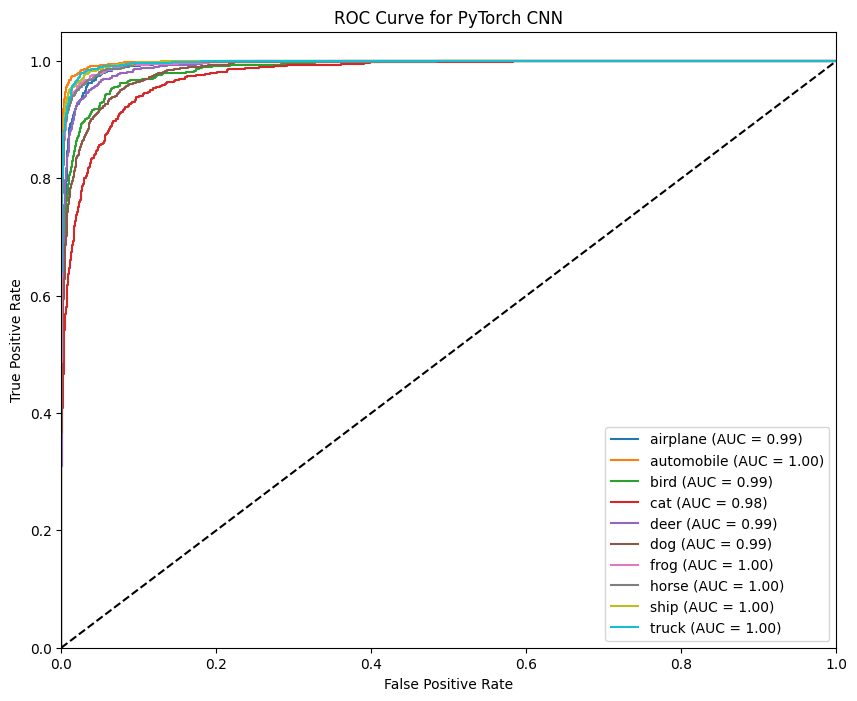


Evaluation Metrics for PyTorch CNN:
Accuracy: 0.8836
Precision (macro): 0.8833
Recall (macro): 0.8836
F1-Score (macro): 0.8832
AUC (macro, OvR): 0.9920


In [ ]:
print("\nEvaluating PyTorch CNN Model:")
cnn_metrics = evaluate_model(pytorch_cnn_model, test_loader, "PyTorch CNN")

Memanggil grafik MLP yang sudah di definisikan diatas


Evaluating PyTorch MLP Model:


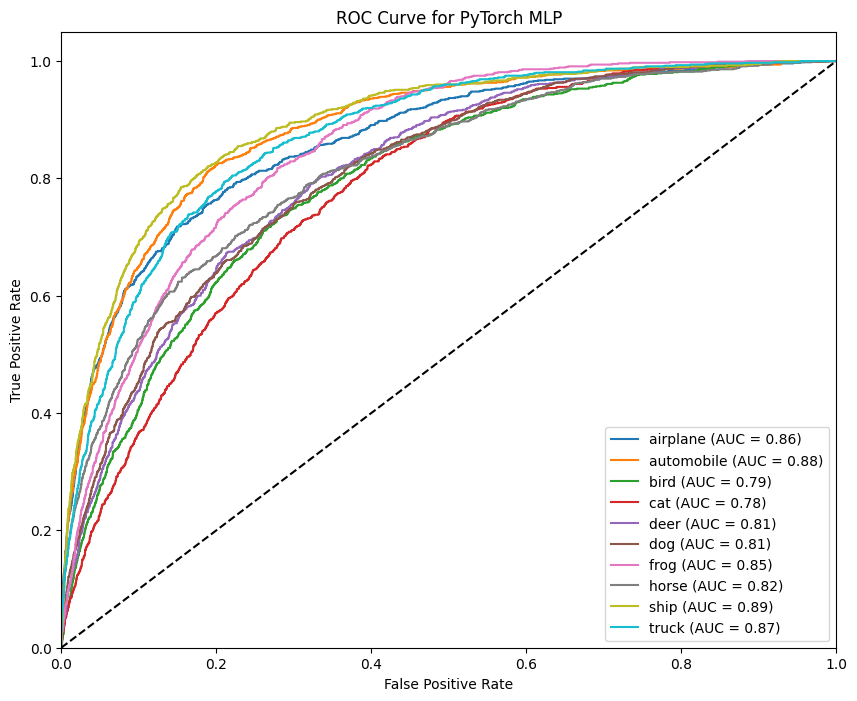


Evaluation Metrics for PyTorch MLP:
Accuracy: 0.3762
Precision (macro): 0.4028
Recall (macro): 0.3762
F1-Score (macro): 0.3612
AUC (macro, OvR): 0.8369


In [ ]:
print("\nEvaluating PyTorch MLP Model:")
mlp_metrics = evaluate_model(pytorch_mlp_model, test_loader, "PyTorch MLP")

Perbandingan Akurasi dan Loss antara CNN dengan MLP

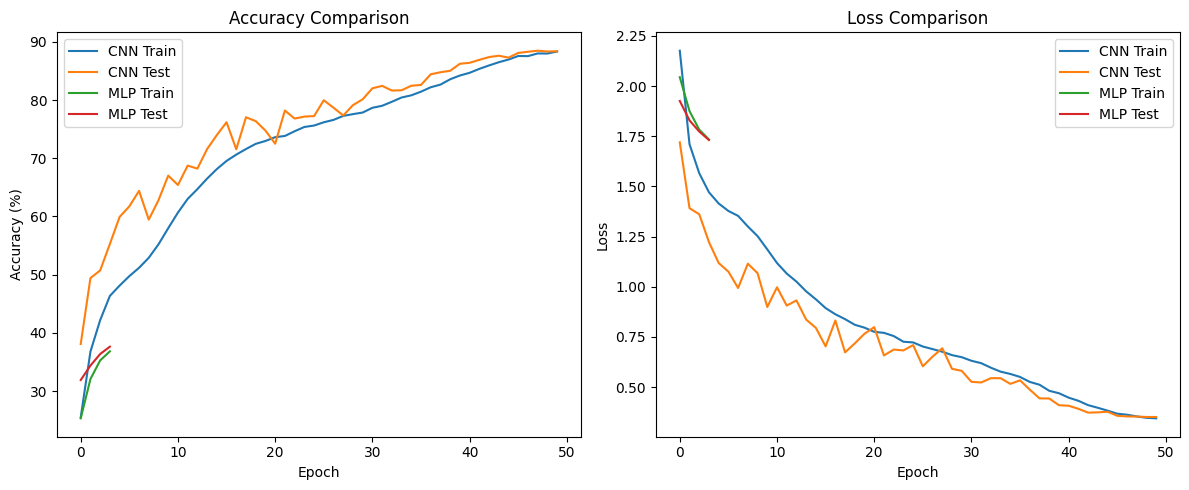

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.plot(pytorch_cnn_train_acc, label='CNN Train')
plt.plot(pytorch_cnn_test_acc, label='CNN Test')
plt.plot(pytorch_mlp_train_acc, label='MLP Train')
plt.plot(pytorch_mlp_test_acc, label='MLP Test')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss comparison
plt.subplot(1, 2, 2)
plt.plot(pytorch_cnn_train_loss, label='CNN Train')
plt.plot(pytorch_cnn_test_loss, label='CNN Test')
plt.plot(pytorch_mlp_train_loss, label='MLP Train')
plt.plot(pytorch_mlp_test_loss, label='MLP Test')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Perbandingan antara menggunakan CNN dan MLP Vanilla:")
print(f"{'Metric':<15} {'CNN':<10} {'MLP':<10}")
print("-" * 35)
for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    print(f"{metric:<15} {cnn_metrics[metric]:.4f}     {mlp_metrics[metric]:.4f}")

Perbandingan antara menggunakan CNN dan MLP Vanilla:
Metric          CNN        MLP       
-----------------------------------
accuracy        0.8836     0.3762
precision       0.8833     0.4028
recall          0.8836     0.3762
f1              0.8832     0.3612
auc             0.9920     0.8369


##Tensorflow

###Data Prepatation

In [100]:
#loading dataset dari tensorflow
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [101]:
#penggunaan one hot encoding
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [102]:
#normalisasi data
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

###CNN

In [103]:
#callback membuat earlystopping(pengurangan terjadinya overfitting) dan scheduler
callbacks =[
    EarlyStopping(monitor='val_loss',patience=5,min_delta=0.001,restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,min_delta=0.001)
]

Modeling CNN

In [104]:
def cnn():
    weight_decay = 1e-4
    model = keras.Sequential([
        layers.Input(shape=(32, 32, 3)),

        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(weight_decay)),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model


Training data dari model cnn diatas

In [105]:
def train_model(model, name, epochs=50):
    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        batch_size=128,
        epochs=epochs,
        callbacks=[early_stop],
        verbose=1
    )

    for epoch in range(len(history.history['accuracy'])):
        train_acc = history.history['accuracy'][epoch] * 100
        test_acc = history.history['val_accuracy'][epoch] * 100
        print(f"Epoch {epoch + 1:>2}/{epochs} {name} Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%")


In [106]:
print("\nTraining TensorFlow CNN:")
cnn_model = cnn()
cnn_history = train_model(cnn_model, "TF CNN")


Training TensorFlow CNN:
Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.3224 - loss: 2.5097 - val_accuracy: 0.1082 - val_loss: 6.5478
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5160 - loss: 1.4789 - val_accuracy: 0.5856 - val_loss: 1.3713
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5966 - loss: 1.2777 - val_accuracy: 0.6358 - val_loss: 1.2077
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6367 - loss: 1.1712 - val_accuracy: 0.5674 - val_loss: 1.5865
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6734 - loss: 1.1053 - val_accuracy: 0.6788 - val_loss: 1.1051
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7079 - loss: 1.0280 - val_accuracy: 0.6893 - val_loss: 1.0743
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7210 - loss: 0.9978 - val_accuracy: 0.7242 - val_loss: 1.0086
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0

###MLP

Pembuatan callback

In [114]:
callbacks =[
    EarlyStopping(monitor='val_loss',patience=5,min_delta=0.001,restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,min_delta=0.001)
]

Modeling MLP

In [115]:
def mlp():
    model = keras.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

Training model MLP yang sudah di buat diatas

In [116]:
def train_model(model, name, epochs=50):
    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        batch_size=64,
        epochs=epochs,
        callbacks=[early_stop],
        verbose=1
    )

    for epoch in range(len(history.history['accuracy'])):
        train_acc = history.history['accuracy'][epoch] * 100
        test_acc = history.history['val_accuracy'][epoch] * 100
        print(f"Epoch {epoch + 1:>2}/{epochs} {name} Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%")


In [117]:
print("Training TensorFlow MLP:")
mlp_model = mlp()
mlp_history = train_model(mlp_model, "TF MLP")

Training TensorFlow MLP:
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.2781 - loss: 2.0427 - val_accuracy: 0.3932 - val_loss: 1.6878
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3979 - loss: 1.6869 - val_accuracy: 0.4312 - val_loss: 1.5894
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4374 - loss: 1.5825 - val_accuracy: 0.4325 - val_loss: 1.5824
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4560 - loss: 1.5195 - val_accuracy: 0.4578 - val_loss: 1.5021
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4737 - loss: 1.4877 - val_accuracy: 0.4508 - val_loss: 1.5342
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4820 - loss: 1.4452 - val_accuracy: 0.4711 - val_loss: 1.4896
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4904 - loss: 1.4308 - val_accuracy: 0.4878 - val_loss: 1.4437
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4993 - loss: 1.3989 - val_accuracy: 0.4907 - val_

###Evaluasi dari CNN dan MLP

In [121]:
def evaluate_tf_model(model, x_test, y_test, model_name="Model"):
    y_probs = model.predict(x_test)
    y_preds = np.argmax(y_probs, axis=1)

    acc = accuracy_score(y_test, y_preds)
    prec = precision_score(y_test, y_preds, average='macro')
    rec = recall_score(y_test, y_preds, average='macro')
    f1 = f1_score(y_test, y_preds, average='macro')
    auc = roc_auc_score(y_test, y_probs, multi_class='ovr', average='macro')

    print(f"\nEvaluation Metrics for {model_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {auc:.4f}")

    plt.figure(figsize=(10, 8))
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_test == i, y_probs[:, i])
        auc_i = roc_auc_score(y_test == i, y_probs[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_i:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc
    }


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Evaluation Metrics for TF MLP:
Accuracy: 0.7757
Precision: 0.7804
Recall: 0.7757
F1 Score: 0.7762
AUC Score: 0.9739


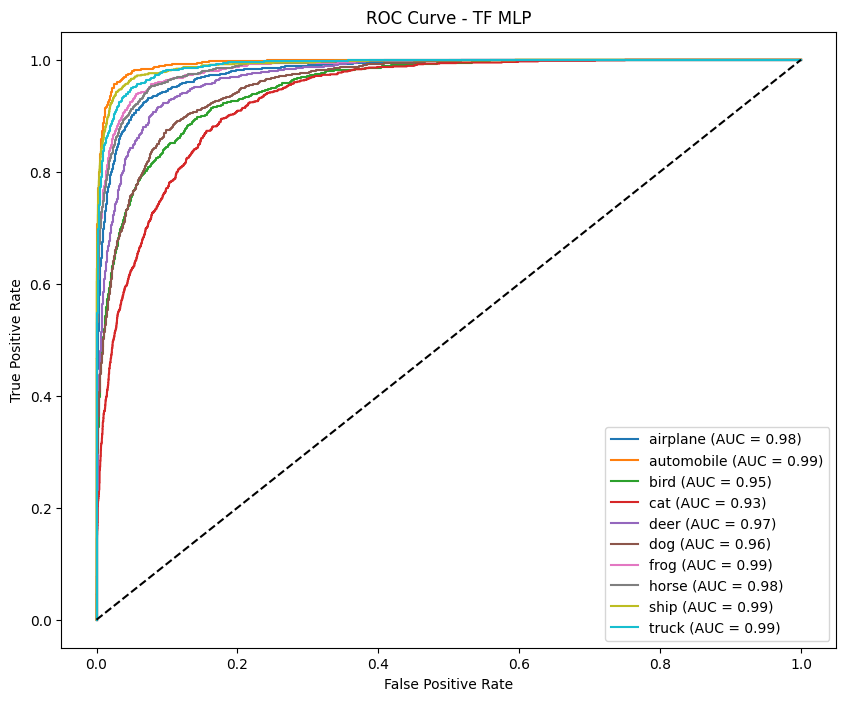

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Evaluation Metrics for TF CNN:
Accuracy: 0.5076
Precision: 0.5117
Recall: 0.5076
F1 Score: 0.5057
AUC Score: 0.8872


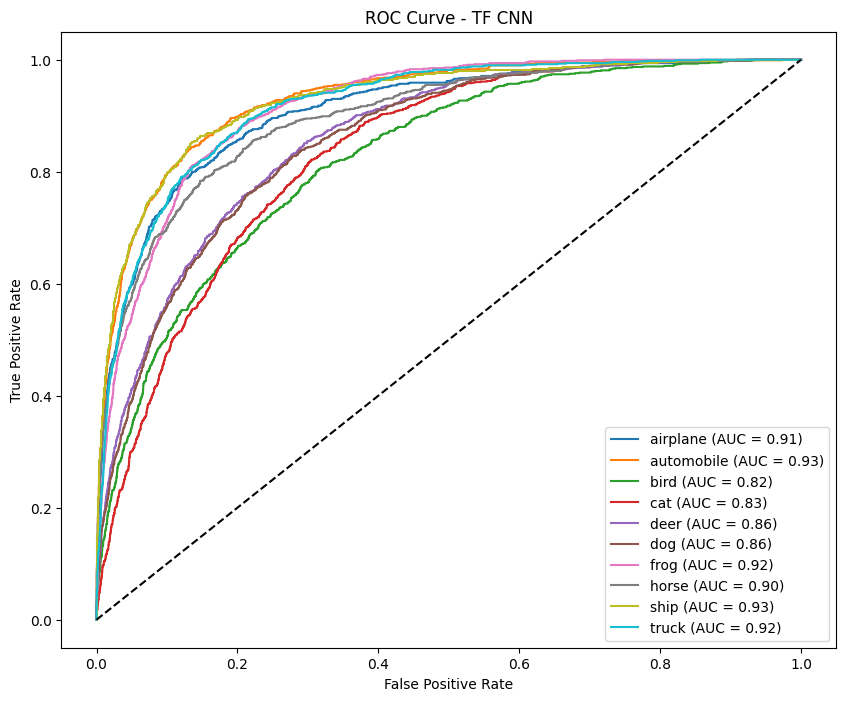

In [122]:
cnn_metrics_tf = evaluate_tf_model(cnn_model, x_test, y_test, "TF MLP")
mlp_metrics_tf = evaluate_tf_model(mlp_model, x_test, y_test, "TF CNN")

In [124]:
print("Pebandingan antara MLP dan CNN")
print(f"{'Metric':<15} {'CNN':<10} {'MLP':<10}")
print("-" * 35)
for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    print(f"{metric:<15} {cnn_metrics_tf[metric]:.4f}     {mlp_metrics_tf[metric]:.4f}")


Pebandingan antara MLP dan CNN
Metric          CNN        MLP       
-----------------------------------
accuracy        0.7757     0.5076
precision       0.7804     0.5117
recall          0.7757     0.5076
f1              0.7762     0.5057
auc             0.9739     0.8872
